<a href="https://colab.research.google.com/github/fernandofsilva/LSTM_Option_Pricing/blob/main/notebooks/01_garch_volatilidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [51]:
#@title Carregar as bibliotecas bases
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

Carregando os dados que foram parseados anteriormente

In [52]:
#@title Carregando os dados de cotações da B3 com o periódo de 2015 até 2020.
raw_data = pd.read_csv('/content/drive/My Drive/Mestrado/data/cotacao_historica.csv.gz')
raw_data.head()

,data_pregao,codigo,mercado,preco,preco_exercicio,data_vencimento
0,2019-01-02,AALR3,VISTA,13.25,0.0,2019-01-02
1,2019-01-02,AAPL34,VISTA,60.41,0.0,2019-01-02
2,2019-01-02,ABBV34,VISTA,342.84,0.0,2019-01-02
3,2019-01-02,ABCB4,VISTA,17.12,0.0,2019-01-02
4,2019-01-02,ABEV3,VISTA,16.15,0.0,2019-01-02


# PETR4

O foco desse trabalho é utilizando o ativo PETR4 e as opções do ativo subjacente.

In [53]:
#@title Filtrando o dataset e selecionando apenas o ativo PETR4
# Filtro para o papel que será analisado
data = raw_data[raw_data['codigo'] == 'PETR4']

# Renomear a coluna preco para não haver duplicada posteriormente
data = data.rename(columns={'preco': 'preco_ativo'})

# Formatar a coluna de data
data['data_pregao'] = pd.to_datetime(data['data_pregao'])
data = data.sort_values(by='data_pregao')
data.index = data['data_pregao']
data = data.drop(['data_pregao', 'codigo', 'mercado', 'preco_exercicio', 'data_vencimento'], axis=1)

data.head()

,preco_ativo
data_pregao,
2015-01-02,9.36
2015-01-05,8.61
2015-01-06,8.33
2015-01-07,8.67
2015-01-08,9.18


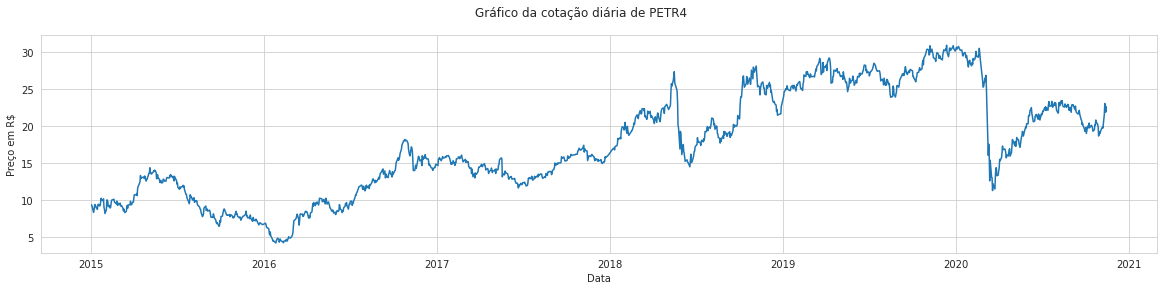

In [54]:
#@title Plot com os dados selecionados
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico da cotação diária de PETR4')
ax.plot(data['preco_ativo'])
ax.set_ylabel('Preço em R$')
ax.set_xlabel('Data')
plt.show()

# GARCH (1,1)

Para o cálculo do valor da opção, também necessário estimar o valor da volitilidade no período, a volitilidade é estimada a partir dos retornos do ativo, dado pela fórmula $\ln\left(\dfrac{S_{i}}{S_{i-1}}\right)$ onde $S$ é o valor do ativo e $i$ o dia.

In [55]:
#@title Cálculo de retornos PETR4
data['retorno'] = np.log(data['preco_ativo'] / data['preco_ativo'].shift(1))
data = data.dropna()
data.head()

,preco_ativo,retorno
data_pregao,,
2015-01-05,8.61,-0.083521
2015-01-06,8.33,-0.033061
2015-01-07,8.67,0.040005
2015-01-08,9.18,0.057158
2015-01-09,9.40,0.023682


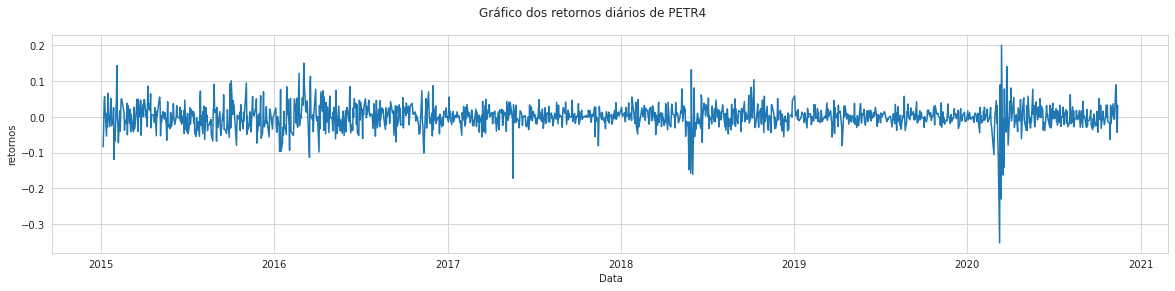

In [56]:
#@title Plot dos retornos de PETR4
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico dos retornos diários de PETR4')
ax.plot(data['retorno'])
ax.set_ylabel('retornos')
ax.set_xlabel('Data')
plt.show()

In [57]:
#@title instalação do pacote arch para modelagem da volatilidade
!pip install arch

In [64]:
#@title Modelo de volatilidade por Garch(1,1)
from arch import arch_model

am = arch_model(data['retorno'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252)
garch = garch.rename("volitilidade")
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3064.278500333146
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                retorno   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                3064.28
Distribution:                  Normal   AIC:                          -6120.56
Method:            Maximum Likelihood   BIC:                          -6099.44
                                        No. Observations:                 1451
Date:                Tue, Nov 17 2020   Df Residuals:                     1447
Time:                        22:59:12   Df Model:                            4
                                  Mean Model                                 
  

In [65]:
#@title Valores de Mu, Omega, Alpha e Beta
result = pd.DataFrame(
    {'coeficientes': res.params.values,
     'erro padrão': res.std_err.values}, 
     index=['mu', 'omega', 'alpha', 'beta']
)

results

,coeficientes,erro padrão
mu,0.001228,0.000714
omega,0.000024,0.000003
alpha,0.100010,0.026850
beta,0.879991,0.018120


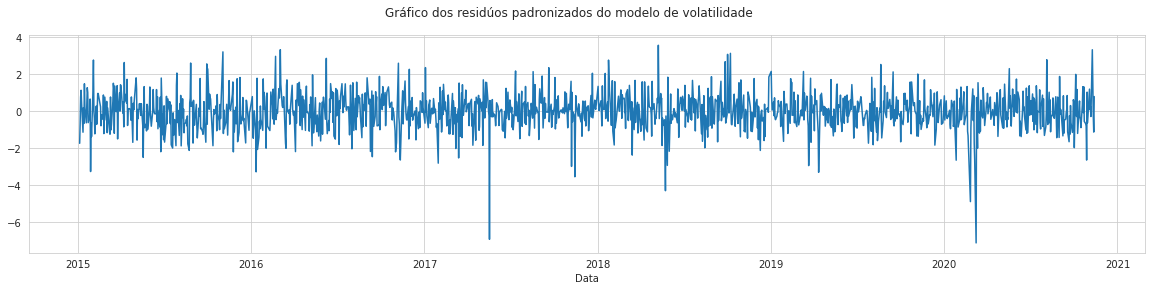

In [66]:
#@title Plot Volatilidade Condicional
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico dos residúos padronizados do modelo de volatilidade')
axs.plot(res.std_resid)
axs.set_xlabel('Data')
plt.show()

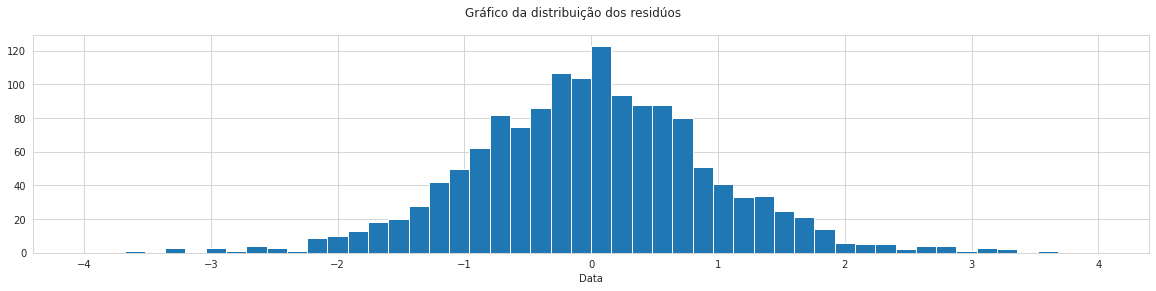

In [67]:
#@title Plot Distribuição dos Residúos
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico da distribuição dos residúos')
axs.hist(res.std_resid, bins=50, range=(-4, 4))
axs.set_xlabel('Data')
plt.show()

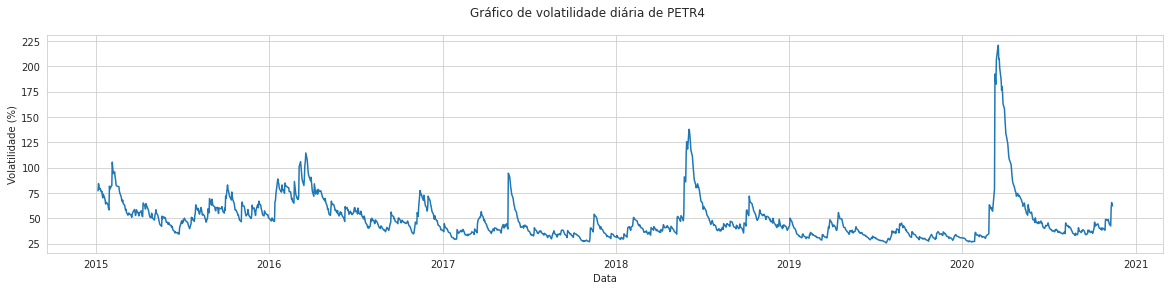

In [68]:
#@title Plot Volatilidade Condicional
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Gráfico de volatilidade diária de PETR4')
axs.plot(garch * 100)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

In [71]:
#@title Juntar os dados e salvar Csv
data = data[['preco_ativo']].merge(right=garch, right_index=True, left_index=True)
data.head()

,preco_ativo,volitilidade
data_pregao,,
2015-01-05,8.61,0.771953
2015-01-06,8.33,0.843418
2015-01-07,8.67,0.813362
2015-01-08,9.18,0.791204
2015-01-09,9.40,0.797282


Os dados estão salvos dentro do meu Google Drive, porém estão disponíveis através do site da bovespa e também dentro do [Github](https://github.com/fernandofsilva/LSTM_Option_Pricing/tree/main/data) do projeto.

In [72]:
#@title Salvar Csv
data.to_csv('/content/drive/My Drive/Mestrado/data/volatilidade_garch.csv.gz', compression='gzip')